# Importation of the required Python modules

In [1]:
import sys
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import Image
except ImportError:
    from PIL import Image
Image
import numpy as np # !!! numpy v2.0.0 (juin 2024) incompatible avec myqlm. Downgrade à la version 1.26.4

In [2]:
from importlib.metadata import version 
version('myqlm')

'1.9.9'

In [3]:
import numpy as np
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.lang.AQASM import Program, I, X, RX, RY, RZ, CNOT
from qat.core import Term
from qat.fermion import FermionHamiltonian
from qat.fermion.transforms import transform_to_jw_basis
from qat.qpus import get_default_qpu, PyLinalg
from qat.plugins import ScipyMinimizePlugin

# 1. Hardware Efficient Ansatz (Kandala 2017)

## 1.1. Reminder: Application on H$_2$

In the previous tutorial on performing VQE for the H$_2$ molecule, you have seen the application of the Hardware Efficient Ansatz (HEA) as defined by Kandala and coworkers (https://arxiv.org/abs/1704.05018). This ansatz consists of alternated layers of single-qubit rotations and two-qubit entangling gates. We will consider $R_Y(\theta)$ single-qubit rotation gates and CNOT as the two-qubit gates. They can be arranged in different ways, thus leading to many possible entanglement-strategies, as shown for instance in the IBM implementation (https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal). Maybe you can try to implement these strategies yourself at the end of the tutorial.

The formula of the RyCNOT ansatz is
$$
\hat{\mathcal{U}}(\vec{\theta}) = \prod_{m=1}^M R_{y,m}(\theta_{m_y}^0)\prod_{n=1}^{{N_L}} \hat{\mathcal{U}}_n^{\rm ENT}(\vec{\theta}^n)
$$
for a number of layers ${N_L}$ and a number of qubits $M$.
The linearly-entangled unitary block reads
$$
\hat{\mathcal{U}}_n^{\rm ENT}(\vec{\theta}^n) = 
\prod_{m=1}^{M-1} {\rm CNOT}_{m(m+1)} \prod_{m=1}^M R_{y,m}(\theta_{m}^n).
$$
For instance, the RyCNOT circuit with 4 qubits and 3 layers is the following:

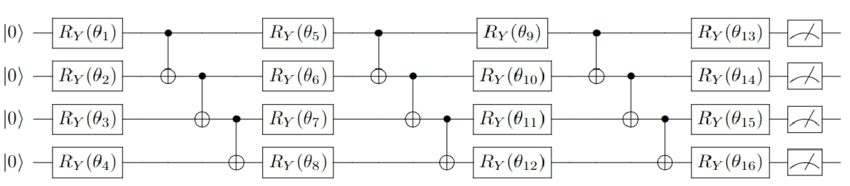

Let us recall the functions that we have built in the previous tutorial:

In [4]:
def Build_HF_circuit(nqbits, n_electrons):
    '''
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    Function to build a quantum circuit that prepares the Hartree-Fock (HF) state for a given 
    number of electrons in a specified register of qubits. The Hartree-Fock state is created by 
    initializing the first `n_electrons` qubits to the |1⟩ state and leaving the rest in the |0⟩ state.
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    Parameters:
    qubits_register: List of qubits that will be used in the circuit.
    n_electrons: Integer specifying the number of electrons to be represented in the circuit.
    
    Returns:
    HF_state_circuit: A circuit object representing the initialized HF state.
    '''
    
    # Create a new quantum program to build the HF state circuit
    prog = Program()
    
    # Allocate qubits in the register for the specified number of qubits
    register = prog.qalloc(nqbits)  
    
    # Initialize the first `n_electrons` qubits to the |1⟩ state using X gates
    for index_qubit in range(n_electrons):
        X(register[index_qubit])  # Apply X gate to set qubit to |1⟩

    # Convert the program into a circuit representation
    HF_circuit = prog.to_circ()
    
    return HF_circuit  # Return the constructed Hartree-Fock state circuit

def Build_RyCNOT_circuit(nqubits,n_layers):
    # Create a new quantum program to build the HF state circuit
    prog = Program()
    
    # Allocate qubits in the register for the specified number of qubits
    register = prog.qalloc(nqbits)  

    theta_list = [prog.new_var(float, "\\theta_{%s}" % i) for i in range((n_layers+1)*nqbits)]

    # Consider the number of layers
    for layer in range(n_layers):
        # Apply the Ry single-qubit gates:
        for qubit in range(nqbits):
            RY(theta_list[qubit+nqbits*layer])(register[qubit])
        # Apply the CNOT entangling gates:
        for qubit in range(nqbits-1):
            CNOT(register[qubit], register[qubit+1])

    # Apply one last single-qubit Ry layer:
    for qubit in range(nqbits):
        RY(theta_list[qubit+nqbits*n_layers])(register[qubit])

    HEA_circuit = prog.to_circ()
    return HEA_circuit

## 1.2. Application on HeH$^+$

Let us now consider another problem of the same size: HeH$^+$, with two electrons and two spatial orbitals within the STO-3G basis set.
We first construct the qubit-Hamiltonian using the Jordan-Wigner encoding, and we apply VQE with the HEA to compute the ground-state energy.
We see that the VQE energy matches the one obtained by exact diagonalization of the qubit-Hamiltonian matrix.

If you want to use PySCF to generate the molecular Hamiltonian, you can use the following function that exists in MyQLM (if you have PySCF installed):

In [5]:
#from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
#geometry = [
#    ("He", (0.0, 0.0, 0.0)),
#    ("H", (0.0, 0.0, 1.5))
#]
#basis = "sto-3g"  
#spin = 0
#charge = 1

#(   rdm1,
#    orbital_energies,
#    nuclear_repulsion,
#    n_electrons,
#    one_body_integrals,
#    two_body_integrals,
#    info,) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)

#np.savez('HeH+.npz',
#         rdm1=rdm1,
#        orbital_energies=orbital_energies,
#        nuclear_repulsion=nuclear_repulsion,
#        n_electrons=n_electrons,
#        one_body_integrals=one_body_integrals,
#        two_body_integrals=two_body_integrals,
#        info=info)

And if you don't have PySCF, use already stored data:

In [6]:
heh_data = np.load("HeH+.npz", allow_pickle=True)

rdm1 = heh_data["rdm1"]
orbital_energies = heh_data["orbital_energies"]
nuclear_repulsion = heh_data["nuclear_repulsion"]
n_electrons = heh_data["n_electrons"]
one_body_integrals = heh_data["one_body_integrals"]
two_body_integrals = heh_data["two_body_integrals"]
info = heh_data["info"].tolist()

# Define the molecular hamiltonian
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

# Compute the ElectronicStructureHamiltonian
H = mol_h.get_electronic_hamiltonian()

H_q = transform_to_jw_basis(H)

Let's look at the shape of our Harware efficient circuit

In [7]:
nqbits = len(rdm1[0])*2
n_layers = 1
total_circuit = Build_HF_circuit(nqbits, n_electrons) + Build_RyCNOT_circuit(nqbits,n_layers)
total_circuit.display()

Let's find the ground-state energy

In [8]:
job = total_circuit.to_job(observable=H_q)#, nbshots=0)

optimizer_scipy = ScipyMinimizePlugin(method="SLSQP", x0 = [0]*(nqbits+1)*n_layers, options={"maxiter": 1000})
qpu = optimizer_scipy | PyLinalg() # get_default_qpu()
result = qpu.submit(job)

print("Minimum energy =", result.value)

Minimum energy = -3.2487777324340392


And compare it with exact diagonalization:

In [9]:
np.linalg.eigh(H_q.get_matrix())[0]

array([-3.25421976, -3.25421976, -2.91567691, -2.82468268, -2.37582867,
       -2.37582867, -2.37437424, -2.37437424, -2.37437424, -2.33753775,
       -1.5788635 , -1.5788635 , -0.7822502 , -0.4299384 , -0.4299384 ,
        0.70556961])

Now, let's compare with the FCI energy.

In [10]:
print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)

 HF energy :  -2.823449750033749
 MP2 energy : -2.824793686592509
 FCI energy : -2.8246826761898034



Clearly, the FCI energy is much higher than the one obtained by VQE, which was supposed to be variational.
Any idea of what is happening? How can we deal with this problem ?

# 2. Physically-inspired ansatz: Unitary Coupled Cluster

Another possibility is to design a physically-inspired ansatz. The most well-known one is the unitary version of the coupled cluster method (UCC). UCC is intractable classically and is variational, in contrast to traditional (projected) CC.

## 2.1. Unitary Coupled Cluster

$$\displaystyle
\hat{U}(\vec{\theta}) = e^{\hat{T}(\vec{\theta}) - \hat{T}^\dagger(\vec{\theta})}
$$
with $\hat{T}(\vec{\theta}) = \sum_n^{\text{exc. op.}} \theta_n \hat{\tau}_n$ and $\hat{\tau}_n$ is any excitation operator in the form
$\hat{a}_p^\dagger \hat{a}_q$ for single-excitation, $\hat{a}_p^\dagger \hat{a}_q^\dagger \hat{a}_r \hat{a}_s$ for double-excitation, etc.
Hence,
$$
\hat{U}(\vec{\theta}) = \displaystyle e^{\sum_n^{\text{exc. op.}} \theta_n (\hat{\tau}_n - \hat{\tau}_n^\dagger)}
$$

## 2.2. Unitary Coupled Cluster on Quantum Computer

We have to transform the fermionic unitary coupled cluster ansatz onto a form that can be executed on a quantum computer, i.e. using Pauli strings:
$$
\hat{U}(\vec{\theta}) = \displaystyle e^{\sum_n^{\text{exc. op.}} \theta_n (\hat{\tau}_n - \hat{\tau}_n^\dagger)} 
= \displaystyle e^{\sum_n^{\text{exc. op.}} \theta_n \sum_j \hat{P}_j^{(n)}} 
$$
up to some scalar pre-factor which depends on the degree of excitation of $\hat{\tau}_n$.
We know how to implement the exponentiation of a Pauli string $e^{\theta \hat{P}}$ (see Saad's lecture). But not the exponential of a sum of Pauli strings $e^{\sum_j \theta_j \hat{P}_j}$! If all the Pauli strings commute, then $e^{\sum_j \theta_j \hat{P}_j} = \prod_j e^{\theta_j \hat{P}_j}$, which is not 
 always the case.
Hence, we will use the Trotter-Kato formula, which reads for two non-commuting matrices:
$$
{\displaystyle \mathrm {e} ^{(X+Y)}=\lim _{t\to \infty }\left(\mathrm {e} ^{\frac {X}{t}}\mathrm {e} ^{\frac {Y}{t}}\right)^{\!t}}.
$$
Within VQE, we usually use the first-order approximation ($t=1$) such that:
$$
\hat{U}(\vec{\theta}) = \displaystyle e^{\sum_n^{\text{exc. op.}} \theta_n \sum_j \hat{P}_j^{(n)}} \simeq \prod_n^{\text{exc. op.}} e^{\theta_n \sum_j \hat{P}_j^{(n)}} =  \prod_n^{\text{exc. op.}} \prod_j e^{\theta_n \hat{P}_j^{(n)}}
$$
Let's implement the exponentiation of a Pauli string.

In [11]:
def Build_Exp_Pauli_Strings(Pauli_String, parameter_name, nqbits):
    '''
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    Function to build a quantum circuit that exponentiates a single parametrized Pauli string.
    The Pauli string is represented by its qubits and associated operators, and the circuit 
    prepares the state corresponding to the exponential of the given Pauli string.
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    ''' 
    prog = Program()  # Create a new quantum program
    register = prog.qalloc(nqbits)  # Allocate quantum registers for the specified qubits
    
    # Prepare a list of Pauli string elements with their corresponding qubit indices
    Pauli_string_elements = []
    for i in range(len(Pauli_String.qbits)):
        Pauli_string_elements.append([Pauli_String.qbits[i], list(Pauli_String.op)[i]])

    # Left part of the circuit :
    # Apply initial rotations based on the Pauli operators (X, Y, Z)
    for index_qubit, Pauli_op in Pauli_string_elements: 
        if Pauli_op == 'X':
            RY(-np.pi / 2.)(register[index_qubit])  # Apply Y rotation for X operator
        elif Pauli_op == 'Y':
            RX(np.pi / 2.)(register[index_qubit])  # Apply X rotation for Y operator
        elif Pauli_op == 'Z':
            I(register[index_qubit])  # Identity for Z operator
    
    # Middle part of the circuit : 
    # Extend the chain of CNOT gates for the required qubits to match the length of the Pauli string
    if len(Pauli_String.qbits) > 1:
        for j in range(len(Pauli_String.qbits) - 1): 
            CNOT(register[Pauli_string_elements[j][0]],  # Control qubit
                 register[Pauli_string_elements[j + 1][0]])  # Target qubit
            
    # Apply a Z rotation gate on the last qubit of the Pauli string with the appropriate sign
    sign = np.sign(Pauli_String.coeff)  
    RZ(sign * parameter_name)(register[Pauli_string_elements[-1][0]]) 
    
    # Extend the chain of CNOT gates in the reverse direction to match the Pauli string
    if len(Pauli_String.qbits) > 1:
        for j in range(len(Pauli_String.qbits) - 1, 0, -1): 
            CNOT(register[Pauli_string_elements[j - 1][0]],
                 register[Pauli_string_elements[j][0]])
    
    # Right part of the circuit:
    # Apply rotations again based on the Pauli operators to complete the circuit
    for index_qubit, Pauli_op in Pauli_string_elements: 
        if Pauli_op == 'X':
            RY(np.pi / 2.)(register[index_qubit])  # Reverse Y rotation for X operator
        elif Pauli_op == 'Y':
            RX(-np.pi / 2.)(register[index_qubit])  # Reverse X rotation for Y operator
        elif Pauli_op == 'Z':
            I(register[index_qubit])  # Identity for Z operator
            
    circuit = prog.to_circ()  # Convert the program to a circuit representation
    
    return circuit  # Return the constructed circuit

In [12]:
def Build_UCC_circuit(nqbits, docc_MO_indices, virt_MO_indices):
    '''
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    Function to build a quantum circuit for the Unitary Coupled Cluster (UCC) ansatz. This 
    includes generating excitation operators for double and single excitations based on the 
    given indices of doubly occupied (docc) and virtual molecular orbitals (MO). The function 
    constructs fragments of the circuit corresponding to these excitation operators and 
    combines them into the final UCC circuit.
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    Parameters:
    qubits_register: List of qubits that will be used in the circuit.
    docc_MO_indices: List of indices corresponding to the doubly occupied molecular orbitals.
    virt_MO_indices: List of indices corresponding to the virtual molecular orbitals.
    
    Returns:
    UCC_circuit: A circuit object representing the constructed UCC ansatz.
    theta_ini: A list of initial parameters (theta values) for the excitation operators.
    '''
    
    # Initialize a list to hold circuit fragments for each excitation operator
    List_circuit_fragments = [] 
    theta_ini = []  # List to store initial values of cluster amplitudes
    
    # Counter for indexing the theta parameters for the excitations
    counter = 0

    prog = Program()  # Create a new quantum program
    register = prog.qalloc(nqbits)  # Allocate qubits in the program

    # Generating single excitation operators
    for MO_i in docc_MO_indices:
        for MO_a in virt_MO_indices: 
            # Construct the single excitation Hamiltonian
            Single_excitation = FermionHamiltonian(nqbits, [Term(1, "Cc", [2*MO_a, 2*MO_i]), Term(1, "Cc", [2*MO_a + 1, 2*MO_i + 1])])
            Single_excitation -= FermionHamiltonian(nqbits, [Term(1, "Cc", [2*MO_i, 2*MO_a]), Term(1, "Cc", [2*MO_i + 1, 2*MO_a + 1])])
            
            # Transform the single excitation operator to the Jordan-Wigner basis
            JW_Single_excitation = transform_to_jw_basis(Single_excitation)
            
            # Initialize the parameter for this excitation operator
            theta_ini +=  [ 0 ]
            
            # Build the circuit fragments for each term of the single excitation
            for element in range(len(JW_Single_excitation.terms)):
                List_circuit_fragments.append(Build_Exp_Pauli_Strings(
                    JW_Single_excitation.terms[element],
                    Program().new_var(float, '\\theta_%s' % counter),
                    nqbits
                ))
            counter += 1  # Increment the counter for the next excitation operator
            
    # Generating double excitation operators
    for MO_i in docc_MO_indices:
        for MO_j in docc_MO_indices:
            for MO_a in virt_MO_indices: 
                for MO_b in virt_MO_indices: 
                    # Construct the double excitation Hamiltonian
                    Double_excitation = FermionHamiltonian(nqbits, [
                        Term(1, "CCcc", [2*MO_b, 2*MO_a, 2*MO_j, 2*MO_i]),
                        Term(1, "CCcc", [2*MO_b + 1, 2*MO_a + 1, 2*MO_j + 1, 2*MO_i + 1]),
                        Term(1, "CCcc", [2*MO_b, 2*MO_a + 1, 2*MO_j + 1, 2*MO_i]),
                        Term(1, "CCcc", [2*MO_b + 1, 2*MO_a, 2*MO_j, 2*MO_i + 1])
                    ]) 
                    
                    # Subtracting the corresponding Daggered terms for double excitations
                    Double_excitation -= FermionHamiltonian(nqbits, [
                        Term(1, "CCcc", [2*MO_i, 2*MO_j, 2*MO_a, 2*MO_b]),
                        Term(1, "CCcc", [2*MO_i + 1, 2*MO_j + 1, 2*MO_a + 1, 2*MO_b + 1]),
                        Term(1, "CCcc", [2*MO_i, 2*MO_j + 1, 2*MO_a + 1, 2*MO_b]),
                        Term(1, "CCcc", [2*MO_i + 1, 2*MO_j, 2*MO_a, 2*MO_b + 1])
                    ]) 
                    
                    # Transforming the excitation operator to the Jordan-Wigner basis
                    JW_Double_excitation = transform_to_jw_basis(Double_excitation)
                    
                    # Initialize the parameter for this excitation operator
                    theta_ini.append(0)
                    
                    # Build the circuit fragments for each term of the double excitation
                    for element in range(len(JW_Double_excitation.terms)):
                        List_circuit_fragments.append(Build_Exp_Pauli_Strings(
                            JW_Double_excitation.terms[element],
                            Program().new_var(float, '\\theta_%s' % counter),
                            nqbits
                        ))
                    counter += 1  # Increment the counter for the next excitation operator
            
    # Building the global architecture of the UCC circuit
    UCC_circuit = prog.to_circ()  # Convert the program to a circuit representation
    
    # Add all circuit fragments to the UCC circuit
    for Circuit_fragment in List_circuit_fragments:
        UCC_circuit += Circuit_fragment
        
    return UCC_circuit, theta_ini  # Return the constructed UCC circuit and initial parameters (set to zero)

In [13]:
nqbits = rdm1.shape[0] * 2

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)
print(f"Number of qubits before active space selection = {rdm1.shape[0] * 2}")
print("Number of qubits = ", nqbits)

 HF energy :  -2.823449750033749
 MP2 energy : -2.824793686592509
 FCI energy : -2.8246826761898034

Number of qubits before active space selection = 4
Number of qubits =  4


In [14]:
# Build the HF circuit circuit
HF_circuit = Build_HF_circuit(nqbits, n_electrons)
# HF_circuit.display()

docc_MO_indices = [i for i in range(n_electrons//2)]
virt_MO_indices = [i for i in range(n_electrons//2, nqbits//2)]

# Build the UCC circuit
UCC_circuit, theta_ini = Build_UCC_circuit(nqbits, docc_MO_indices, virt_MO_indices )
# UCC_circuit.display()

#Build the total circuit (HF + UCC)
Total_circuit = HF_circuit + UCC_circuit
# Total_circuit.display()

In [15]:
# Define the molecular hamiltonian
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

# Compute the ElectronicStructureHamiltonian
H = mol_h.get_electronic_hamiltonian()

# Transform the ElectronicStructureHamiltonian into a qubit Hamiltonian
H_qubit = transform_to_jw_basis(H)

In [16]:
# construct a (variational) job with the variational circuit and the observable
job = Total_circuit.to_job(observable=H_qubit)

# we now build a stack that can handle variational jobs
qpu = PyLinalg() # get_default_qpu()
optimizer_scipy = ScipyMinimizePlugin(method="SLSQP",
                                        tol=1e-6,
                                        options={"maxiter": 1000},
                                        x0=theta_ini)
stack = optimizer_scipy | qpu

# we submit the job and print the optimized variational energy (the exact GS energy is -3)
result = stack.submit(job)
# the output of the optimizer can be found here
print(result.meta_data['optimizer_data'])
print(f"Minimum VQE energy = {result.value}")

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.824682670289182
       x: [-9.938e-03  6.510e-03]
     nit: 3
     jac: [-3.666e-05 -8.622e-04]
    nfev: 12
    njev: 3
Minimum VQE energy = -2.824682670289182


# 3. Design your own ansatz

Find the best ansatz for the $H_4$ ring. The closest to the exact ground-state energy wins a price!

If you have PySCF, you can use the following cell:

In [17]:
# from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
# phi = 45*np.pi/180.
# R = 1.5
# x = R*np.cos(phi)
# y = R*np.sin(phi)
# geometry = [('H', (x,y, 0.)), ('H', (x, -y, 0.)), ('H', (-x,y, 0.)), ('H', (-x, -y, 0.))]

# basis = "sto-3g"  
# spin = 0
# charge = 0

# (   rdm1,
#     orbital_energies,
#     nuclear_repulsion,
#     n_electrons,
#     one_body_integrals,
#     two_body_integrals,
#     info,) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)

# np.savez('H4_square.npz',
#         rdm1=rdm1,
#         orbital_energies=orbital_energies,
#         nuclear_repulsion=nuclear_repulsion,
#         n_electrons=n_electrons,
#         one_body_integrals=one_body_integrals,
#         two_body_integrals=two_body_integrals,
#         info=info)

Otherwise, use already stored data:

In [18]:
H4_data = np.load("H4_square.npz", allow_pickle=True)

rdm1 = H4_data["rdm1"]
orbital_energies = H4_data["orbital_energies"]
nuclear_repulsion = H4_data["nuclear_repulsion"]
n_electrons = H4_data["n_electrons"]
one_body_integrals = H4_data["one_body_integrals"]
two_body_integrals = H4_data["two_body_integrals"]
info = H4_data["info"].tolist()

# Define the molecular hamiltonian
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)

# Compute the ElectronicStructureHamiltonian
H = mol_h.get_electronic_hamiltonian()
#print(f"\n ElectronicStructureHamiltonian:, {H} \n")

H_q = transform_to_jw_basis(H)

 HF energy :  -1.415842881650497
 MP2 energy : -1.5897221012721496
 FCI energy : -1.8887836955936268

